# NLP: Análisis sentimientos de textos turisticos

**Objetivo**:

- Desarrollar un modelo de análisis de sentimientos que clasifique automáticamente las reseñas de lugares turisticos según su polaridad, mediante la aplicación de técnicas de procesamiento de lenguaje natural, extracción de características y aprendizaje automático.

### Importe de librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
import unicodedata
import spacy
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import collections


### Cargue de información

In [2]:
splits = {'train': 'data/train-00000-of-00001-40d9940488cb84b1.parquet', 'test': 'data/test-00000-of-00001-9cc7bacfd2a73ac7.parquet'}
df = pd.read_parquet("hf://datasets/alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad/" + splits["train"])

c:\Users\Usuario\anaconda3\envs\Pruebas_trabajos\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(df)

                                                     text  label
0       el mejor lugar para comer sushi. excelente lug...      5
1       vista hermosa!. me sorprendió la maravillosa v...      5
2       desastroso. buenas noches,  ante todo explicar...      1
3       todo bien excepto que se niegan a dar vasos de...      3
4       el mejor zoologico de méxico. el ambiente es m...      5
...                                                   ...    ...
176187  gran hotel con buen servicio. hotel muy bueno,...      5
176188  estancia cómoda en la frontera de puebla y tla...      5
176189  encantador. realmente nos gustó quedarnos en e...      5
176190  en general la atención del personal fue excele...      5
176191  una bellesa en la ciudad. exelente lugar debaj...      5

[176192 rows x 2 columns]


**Comentario:** El Dataset está conformado por 176.192 opiniones de lugares turisticos los cuales tienen una etiqueta de calificación del sentimiento. Donde 5 es la mejor calificación y 1 es la peor.

#### División en dataset de entrenamiento y prueba

Se realiza una división en entrenamiento y prueba con las proporciones de 70% y 30% respectivamente.

In [4]:
X = df["text"]
y = df["label"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

# Se convierten a DF para el EDA
df_train = pd.DataFrame({"text": X_train, "label": y_train}).reset_index(drop=True)
df_test = pd.DataFrame({"text": X_test, "label": y_test}).reset_index(drop=True)

### EDA: Análisis exploratorio de datos

A continuación se evaluan varios elementos importantes previo al desarrollo del modelo.

In [5]:
# Completitud de los datos
def analisis_datos(df):
    """
    Analiza la completitud de los datos en un DataFrame.
    Muestra la cantidad de valores NaN, espacios en blanco y el porcentaje de valores faltantes por columna.
    """
    columnas = df.columns.tolist()
    espacios_blanco = [df[col].apply(lambda x: isinstance(x, str) and x.isspace()).sum() for col in columnas]
    nan_counts = df.isna().sum().tolist()
    porcentaje_faltantes = [(nan + esp_blanco) / len(df) * 100 for nan, esp_blanco in zip(nan_counts, espacios_blanco)]

    # Crear DataFrame con los resultados
    resultados_df = pd.DataFrame({
        'Columna': columnas,
        'Espacios en Blanco': espacios_blanco,
        'NaN': nan_counts,
        '% Faltantes': porcentaje_faltantes
    })
    
    # Mostrar los resultados
    print("Resultados:")
    print(resultados_df)

In [6]:
def distribucion_sentimientos(df):
    """
    Genera dos gráficos:
    1. Distribución de las calificaciones en un gráfico de barras.
    2. Relación entre la longitud del comentario y la calificación en un boxplot.
    """
    # Crear figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
    
    # Gráfico 1: Distribución de las calificaciones
    df['label'].value_counts().sort_index().plot(kind='bar', colormap='viridis', ax=axes[0])
    axes[0].set_xlabel('Calificación')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de las Calificaciones')
    
    # Calcular la longitud de los comentarios
    df['longitud'] = df['text'].apply(len)
    
    # Gráfico 2: Longitud del texto según calificación
    sns.boxplot(x=df['label'], y=df['longitud'], ax=axes[1])
    axes[1].set_xlabel('Calificación')
    axes[1].set_ylabel('Longitud del comentario')
    axes[1].set_title('Longitud del Texto según Calificación')

    # Ajustar diseño
    plt.tight_layout()
    plt.show()

In [7]:
analisis_datos(df_train)

Resultados:
  Columna  Espacios en Blanco  NaN  % Faltantes
0    text                   0    0          0.0
1   label                   0    0          0.0


In [8]:
analisis_datos(df_test)

Resultados:
  Columna  Espacios en Blanco  NaN  % Faltantes
0    text                   0    0          0.0
1   label                   0    0          0.0


**Comentarios**:
- Se evaluó la completitud en ambos datasets (entrenamiento y prueba) y se osbervó que no hay espacios en blanco o valores faltantes, por lo que no se debe realizar un preprocesamiento en relación con la completitud.

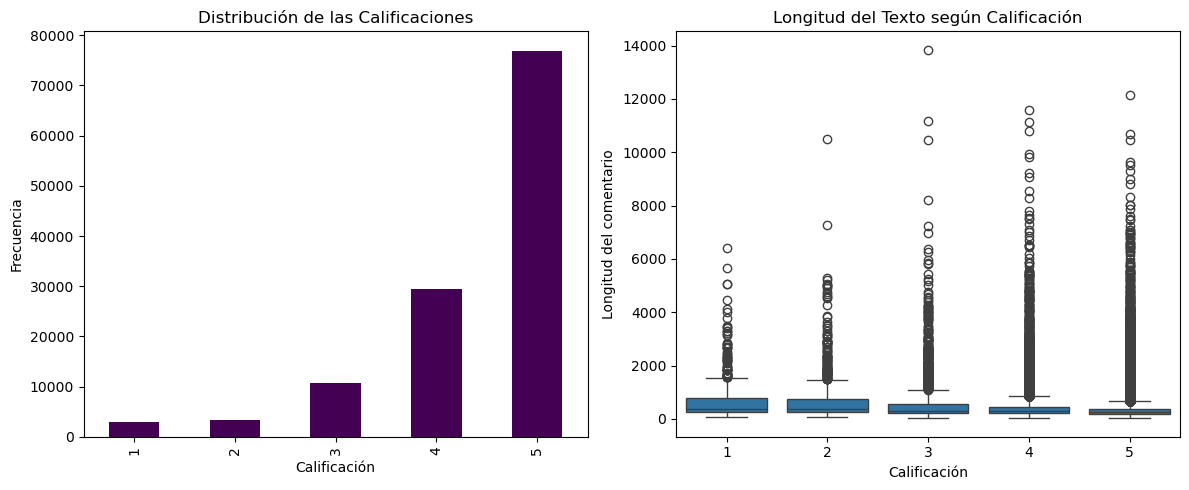

In [9]:
distribucion_sentimientos(df_train)

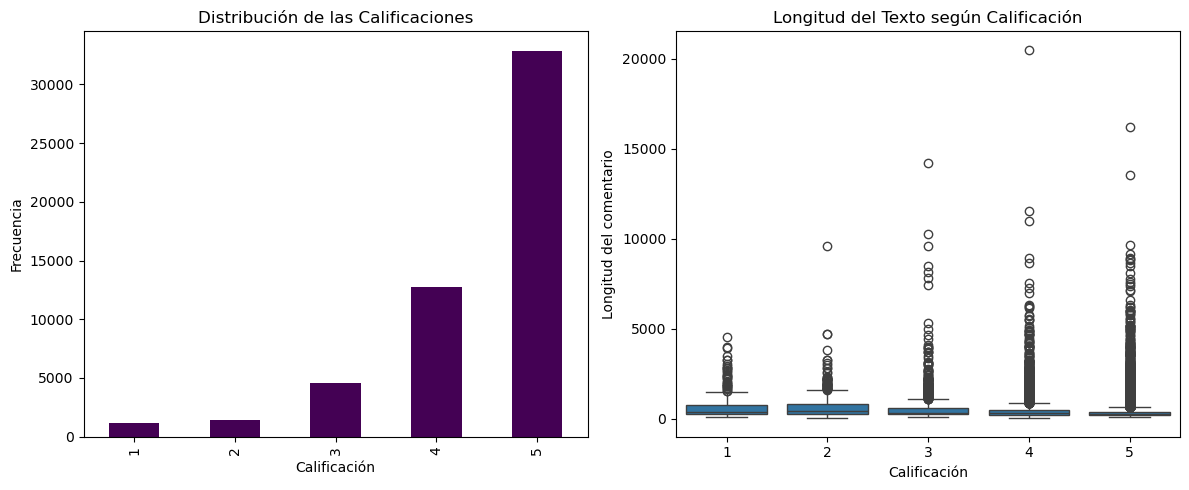

In [10]:
distribucion_sentimientos(df_test)

**Comentarios**: Se observa que los usuarios suelen hacer comentarios en gran parte positivos (clasificación 5 y 4), y que conforme a la disminución de la clasficación también disminuye la longitud del texto.

### Preprocesamiento

Se aplican a continuación técnicas de procesamiento de lenguaje natural (NPL) para extraer información relevante, identificar patrones y facilitar el análisis de los datos. Para ello, se llevaron a cabo las siguientes transformaciones:

* Conversión de texto a minúsculas para estandarizar el tratamiento de los datos.
* Eliminación de tildes y caracteres no alfabéticos para reducir el ruido en el análisis.
* Tokenización con SpaCy, aprovechando su capacidad para manejar raíces en español de manera eficiente.
* Eliminación de stopwords utilizando la librería NLTK. Adicionalmente, debido al contexto del análisis y con el objetivo de mejorar las métricas del modelo, se definió un conjunto de stopwords personalizadas, que fueron removidas al presentar alta frecuencia en todas las calificaciones.
* Aplicación de lematización para reducir las palabras a su forma base, facilitando la identificación de términos clave.

In [ ]:
# Descargar stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("spanish"))
nlp = spacy.load("es_core_news_sm")
stopwords_personalizadas = {"habitacion", "hotel", "restaurante", "servicio", "comida", "lugar", "dia", "noche", "edificio", "piscina", "precio", "ademas", "ma", "habia", "habitaciones", "solo", "si", "no"} 

def preprocesamiento_texto(texto):
    """Preprocesa un texto aplicando limpieza, eliminación de stopwords y 
    lematización"""

    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar tildes
    texto = "".join(
        c for c in unicodedata.normalize("NFD", texto) if unicodedata.category(c) != "Mn"
    )

    # Eliminar caracteres especiales y signos de puntuación
    texto = re.sub(r"[^a-zA-Z\s]", "", texto, flags=re.UNICODE)
    
    # Tokenizar con spaCy
    doc = nlp(texto)

    # Eliminar stopwords
    palabras_filtradas = [token.text for token in doc if token.text not in stop_words and token.text not in stopwords_personalizadas]

    # Lematizar las palabras filtradas
    palabras_lematizadas = [token.lemma_ for token in nlp(" ".join(palabras_filtradas))]

    # Unir palabras procesadas
    texto_preprocesado = " ".join(palabras_lematizadas)

    return texto_preprocesado

def preprocesar_y_vectorizar(X_train, X_test, vectorizer):
    """Preprocesa los textos y aplica vectorización en X_train y X_test."""
    
    # Aplicar preprocesamiento de texto
    X_train_proc = X_train.astype(str).apply(preprocesamiento_texto)
    X_test_proc = X_test.astype(str).apply(preprocesamiento_texto)

    # Ajustar y transformar con el vectorizador
    X_train_vec = vectorizer.fit_transform(X_train_proc)
    X_test_vec = vectorizer.transform(X_test_proc)

    return X_train_proc, X_test_proc, X_train_vec, X_test_vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
vectorizer=CountVectorizer()
#vectorizer = TfidfVectorizer(max_features=1000)
X_train_proc, X_test_proc, X_train_vec, X_test_vec = preprocesar_y_vectorizar(X_train, X_test, vectorizer)

### Desarrollo del modelo de clasificación

#### Ajuste de hiperparámetros y entrenamiento del modelo: Naive Bayes Multinomial

In [46]:
def ajustar_hiperparametros(X_train, y_train):
    """
    Realiza la búsqueda de hiperparámetros para MultinomialNB y devuelve el mejor modelo.
    """
    modelo = MultinomialNB()
    param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
    
    grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Mejor valor de alpha: {grid_search.best_params_['alpha']}")
    
    return grid_search.best_estimator_


best_model = ajustar_hiperparametros(X_train_vec, y_train)

Mejor valor de alpha: 1.0


#### Predicción y evaluación del desempeño del modelo

Accuracy: 0.6690

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.75      0.26      0.38      1191
           2       0.46      0.03      0.06      1458
           3       0.39      0.29      0.33      4594
           4       0.43      0.42      0.43     12744
           5       0.78      0.86      0.82     32871

    accuracy                           0.67     52858
   macro avg       0.56      0.37      0.40     52858
weighted avg       0.65      0.67      0.65     52858



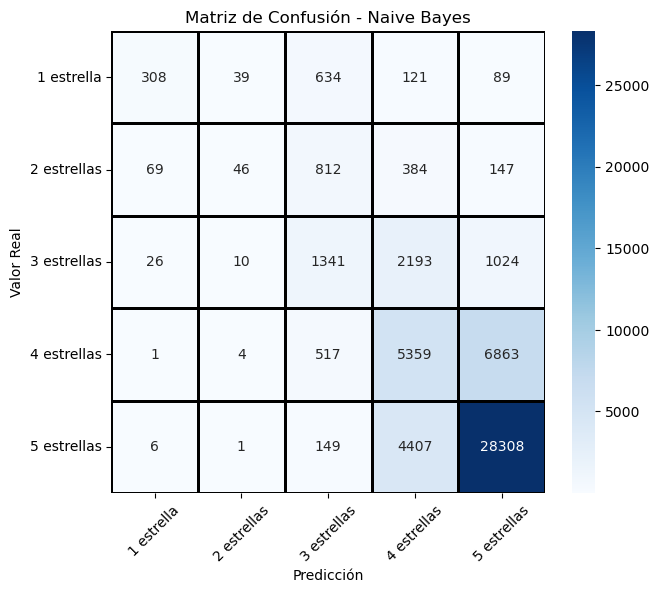

In [51]:
def evaluar_modelo(modelo, X_test, y_test):
    """
    Evalúa el modelo entrenado en los datos de prueba y muestra los resultados.
    """
    # Hacer predicciones
    y_pred = modelo.predict(X_test)

    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Definir etiquetas de clasificación
    labels = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]

    # Crear la figura y los ejes
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black',
                xticklabels=labels, yticklabels=labels)

    # Etiquetas y título
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title("Matriz de Confusión - Naive Bayes")
    plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
    plt.yticks(rotation=0)
    plt.show()

    return y_pred

# Uso
y_pred = evaluar_modelo(best_model, X_test_vec, y_test)

**Comentarios**: 
- La exactitud del modelo es 66,9%, es decir que 2 de cada 3 casos el modelo predice correctamente la calificación del sentimiento.
- En cuanto a la precisión, aunque en las calificaciones extremas (1 y 5) se obtienen valores alrededor del 70%, los valores intermedios de calificación parecen dificultarsele al modelo.
- El recall varia significativamente en las diferentes calificaciones, especialmente en la calificación 2, ya que solo detecta correctamente el 3% de los casos reales.

A pesar de que la exactitud del modelo es aceptable, se deduce que el modelo está sesgado hacia clasificaciones altas, probablmente por la el desbalanceo de clases (calificaciones de 1 y 2 subrepresentadas). 

Por lo tanto, a continuación se aplica la técnica de SMOTE (Synthetic Minority Over.sampling Technique)por los valores del recall, y porque si se utiliza undersampling, por ejemplo, podria perder información importante de las clases minoritarias.

#### Balanceo de clases

Se aplica el balanceo al conjunto de entrenamiento

In [56]:
# Inicializar SMOTE
smote = SMOTE(random_state=42)  

# Aplicar SMOTE al conjunto de entrenamiento
X_train_bal, y_train_bal = smote.fit_resample(X_train_vec, y_train)

# Ver la distribución de clases después del balanceo
print(collections.Counter(y_train_bal))

Counter({5: 76945, 2: 76945, 4: 76945, 3: 76945, 1: 76945})


#### Reconstrucción del modelo

Se vuelve a calcular el modelo con los datos balanceados

Mejor valor de alpha: 0.5
Accuracy: 0.6255

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.54      0.52      0.53      1191
           2       0.29      0.24      0.26      1458
           3       0.38      0.42      0.40      4594
           4       0.40      0.55      0.46     12744
           5       0.83      0.71      0.76     32871

    accuracy                           0.63     52858
   macro avg       0.49      0.49      0.48     52858
weighted avg       0.67      0.63      0.64     52858



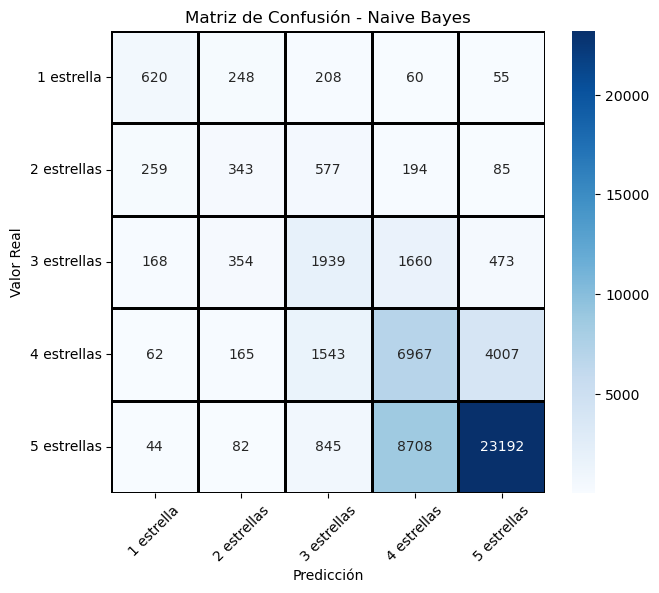

In [57]:
best_model_smote = ajustar_hiperparametros(X_train_bal, y_train_bal)
y_pred_smote = evaluar_modelo(best_model_smote, X_test_vec, y_test)

**Conclusiones**:

- El primer modelo calculado, sin el desbalanceo de clases presentó mejores métricas de desempeño que el segundo, esto probablemente se deba a que la distribución de datos de las clases minoritarias son un poco dispersas o no siguen un patrón claro, por lo que SMOTE no fue tan efectivo en este caso.
- Sin embargo, se pretende desarrollar eventualmente otros modelos (por ejemplo, SVM, random forest, o redes neuronales) y comparar su desempeño tanto para el dataset balanceado como desbalanceado.

### Exportación de resultados

Se exportan los resultados del preprocesamiento y se contruye una tabla con la frecuencia de palabras según la clasificación a la que pertenece.

In [58]:
def export_to_excel(X_proc, y_proc, filename):
    """
    Exporta los datos procesados a un archivo Excel.
    """
    df_proc = pd.concat([X_proc.to_frame(name="Comentario"), y_proc.to_frame(name="Calificacion")], axis=1)
    df_proc.to_excel(filename, index=False)
    return df_proc

def generar_frecuencia_palabras(df, filename):
    """
    Genera el archivo de salida para una gráfica de nubes de palabras
    """
    df["Comentario"] = df["Comentario"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

    palabras_calificadas = [
        (palabra, calificacion) 
        for comentario, calificacion in zip(df["Comentario"], df["Calificacion"])
        for palabra in comentario.split()
    ]
    df_frecuencia = (pd.DataFrame(palabras_calificadas, columns=["Palabra", "Calificacion"]).groupby(["Palabra", "Calificacion"]).size().reset_index(name="Frecuencia"))
    df_frecuencia.to_excel(filename, index=False)

In [59]:
df_train_proc = export_to_excel(X_train_proc, y_train, "../results/nlp/train_proc.xlsx")
df_test_proc = export_to_excel(X_test_proc, y_test, "../results/nlp/test_proc.xlsx")

generar_frecuencia_palabras(df_train_proc, "../results/nlp/frec_palabras_train.xlsx")
generar_frecuencia_palabras(df_test_proc, "../results/nlp/frec_palabras_test.xlsx")

## Modelo interactivo

In [78]:
def predecir_texto_manual(texto, vectorizador, modelo):
    """Preprocesa un texto ingresado manualmente, lo preprocesa y predice su calificación."""
    
    # Aplicar preprocesamiento al texto
    texto_proc = preprocesamiento_texto(texto)
    
    # Transformar con el vectorizador (sin ajuste para mantener consistencia)
    texto_vec = vectorizador.transform([texto_proc])

    # Hacer la predicción
    prediccion = modelo.predict(texto_vec)

    return prediccion[0]

texto_manual = input("Ingrese una reseña del lugar turístico: ")

# Predecir y mostrar el resultado
calificacion = predecir_texto_manual(texto_manual, vectorizer, best_model)
print(f"La calificación predicha para el texto es: {calificacion}")

La calificación predicha para el texto es: 5
